### 1. Préparation du pipeline et des modèles
Modèles utilisés :
Logistic Regression
Naive Bayes
Random Forest
Gradient Boosting

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Charger les données
data = pd.read_csv("Airline_Dataset.csv")

# Renommer les colonnes
data.rename(columns=lambda x: x.strip().replace(" ", "_").lower(), inplace=True)

# Gérer les valeurs manquantes
data["arrival_delay_in_minutes"] = data["arrival_delay_in_minutes"].fillna(
    data["arrival_delay_in_minutes"].median()
)

# Combiner les retards
data["total_delay"] = data["departure_delay_in_minutes"] + data["arrival_delay_in_minutes"]

# Étiqueter la satisfaction
data["satisfaction"] = data["satisfaction"].apply(lambda x: 1 if x == "satisfied" else 0)

# Supprimer les colonnes non représentatives
columns_to_drop = ["id", "departure_delay_in_minutes", "arrival_delay_in_minutes"]
data.drop(columns=columns_to_drop, inplace=True)

# Identifier les colonnes catégoriques et numériques
categorical_columns = data.select_dtypes(include=["object"]).columns
numerical_columns = data.select_dtypes(include=["number"]).drop(columns=["satisfaction"]).columns

# Configurer le prétraitement
categorical_preprocessor = OneHotEncoder(drop="first", sparse_output=False)
numerical_preprocessor = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_preprocessor, numerical_columns),
        ("cat", categorical_preprocessor, categorical_columns),
    ]
)

# Diviser les données en caractéristiques (X) et cible (y)
X = data.drop(columns=["satisfaction"])
y = data["satisfaction"]

# Séparer les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Définir les modèles
models = {
    "logistic_regression": Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "naive_bayes": Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", GaussianNB())
    ]),
    "random_forest": Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(random_state=42))
    ]),
    "gradient_boosting": Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", GradientBoostingClassifier(random_state=42))
    ]),
    "ada_boosting": Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", AdaBoostClassifier(random_state=42))
    ]),
    "hist_gradient_boosting": Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", HistGradientBoostingClassifier(random_state=42))
    ])
}

# Tester les modèles avant optimisation
initial_results = {}
for name, pipeline in models.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    initial_results[name] = accuracy_score(y_test, y_pred)
    print(f"Model: {name}")
    print(classification_report(y_test, y_pred))

Model: logistic_regression
              precision    recall  f1-score   support

           0       0.88      0.90      0.89     14690
           1       0.87      0.84      0.85     11286

    accuracy                           0.87     25976
   macro avg       0.87      0.87      0.87     25976
weighted avg       0.87      0.87      0.87     25976

Model: naive_bayes
              precision    recall  f1-score   support

           0       0.86      0.90      0.88     14690
           1       0.86      0.81      0.84     11286

    accuracy                           0.86     25976
   macro avg       0.86      0.86      0.86     25976
weighted avg       0.86      0.86      0.86     25976

Model: random_forest
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     14690
           1       0.97      0.94      0.95     11286

    accuracy                           0.96     25976
   macro avg       0.96      0.96      0.96     25976
weighte

c:\Users\aboys\Documents\Simplon\Machine Learning\Brief_Plane\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Le fichier spécifié est introuvable
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\aboys\Documents\Simplon\Machine Learning\Brief_Plane\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\aboys\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\aboys\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\aboys\anaconda3\Lib\subpr

Model: hist_gradient_boosting
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     14690
           1       0.97      0.94      0.96     11286

    accuracy                           0.96     25976
   macro avg       0.96      0.96      0.96     25976
weighted avg       0.96      0.96      0.96     25976



### 2. Optimisation des modèles avec GridSearchCV

In [2]:
# Configurer les grilles de recherche pour chaque modèle
param_grids = {
    "logistic_regression": {"classifier__C": [0.1, 1, 10]},
    "naive_bayes": {},  # Pas d'hyperparamètres pour GaussianNB
    "random_forest": {"classifier__n_estimators": [100, 200],
                      "classifier__max_depth": [5, 10]},
    "gradient_boosting": {"classifier__learning_rate": [0.01, 0.1],
                          "classifier__n_estimators": [100, 200]},
    "ada_boosting": {
        "classifier__n_estimators": [50, 100, 200],
        "classifier__learning_rate": [0.01, 0.1, 1]
    },
    "hist_gradient_boosting": {
        "classifier__learning_rate": [0.01, 0.1, 0.2],
        "classifier__max_iter": [100, 200],
        "classifier__max_depth": [3, 5, None]
    }
}

# Optimiser les modèles
optimized_results = {}
best_models = {}

for name, pipeline in models.items():
    grid_search = GridSearchCV(pipeline, param_grids[name], cv=5, scoring="accuracy")
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    optimized_results[name] = grid_search.best_score_

    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Optimized Accuracy: {grid_search.best_score_}")

Best parameters for logistic_regression: {'classifier__C': 1}
Optimized Accuracy: 0.8743070600277638
Best parameters for naive_bayes: {}
Optimized Accuracy: 0.8606405917265711
Best parameters for random_forest: {'classifier__max_depth': 10, 'classifier__n_estimators': 100}
Optimized Accuracy: 0.9454785329699119
Best parameters for gradient_boosting: {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 200}
Optimized Accuracy: 0.9517439233726632
Best parameters for ada_boosting: {'classifier__learning_rate': 1, 'classifier__n_estimators': 200}
Optimized Accuracy: 0.9268170622466967
Best parameters for hist_gradient_boosting: {'classifier__learning_rate': 0.1, 'classifier__max_depth': None, 'classifier__max_iter': 200}
Optimized Accuracy: 0.9645345800855791


### 3. Comparer les performances avant et après optimisation

In [3]:
# Comparer les performances avant et après optimisation
for name in models.keys():
    print(f"{name} - Initial Accuracy: {initial_results[name]:.4f}, Optimized Accuracy: {optimized_results.get(name, 'N/A'):.4f}")

logistic_regression - Initial Accuracy: 0.8744, Optimized Accuracy: 0.8743
naive_bayes - Initial Accuracy: 0.8621, Optimized Accuracy: 0.8606
random_forest - Initial Accuracy: 0.9615, Optimized Accuracy: 0.9455
gradient_boosting - Initial Accuracy: 0.9388, Optimized Accuracy: 0.9517
ada_boosting - Initial Accuracy: 0.9163, Optimized Accuracy: 0.9268
hist_gradient_boosting - Initial Accuracy: 0.9621, Optimized Accuracy: 0.9645


### 4. Vérification du surapprentissage/sous-apprentissage

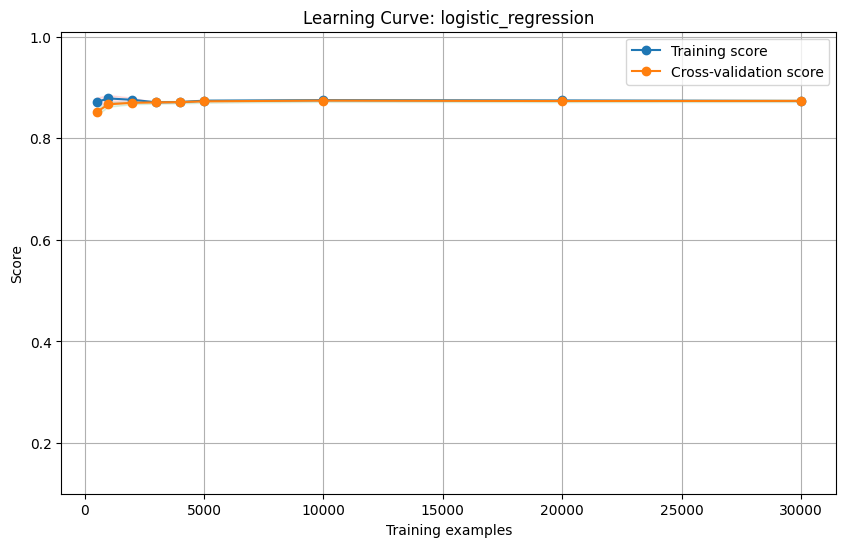

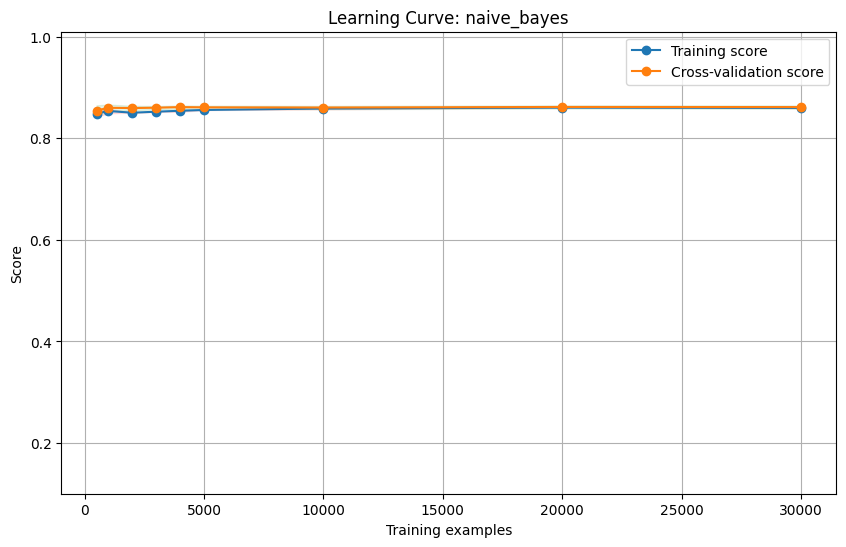

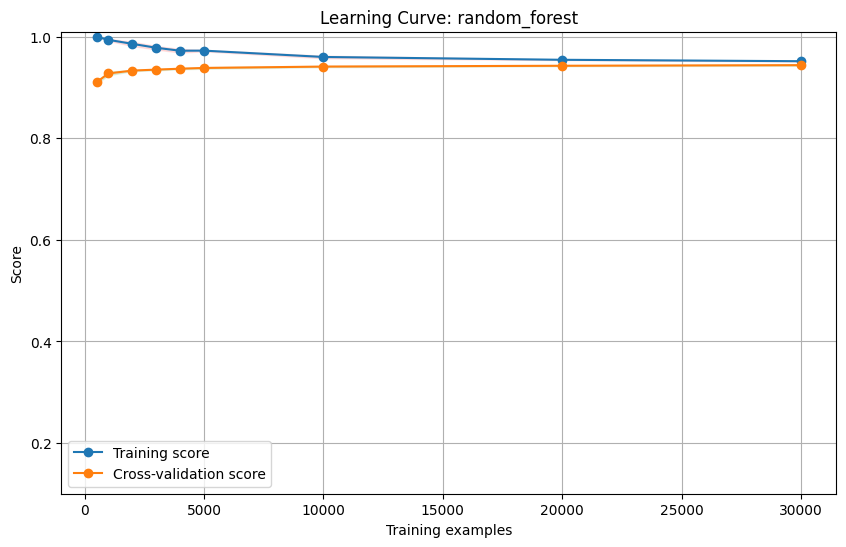

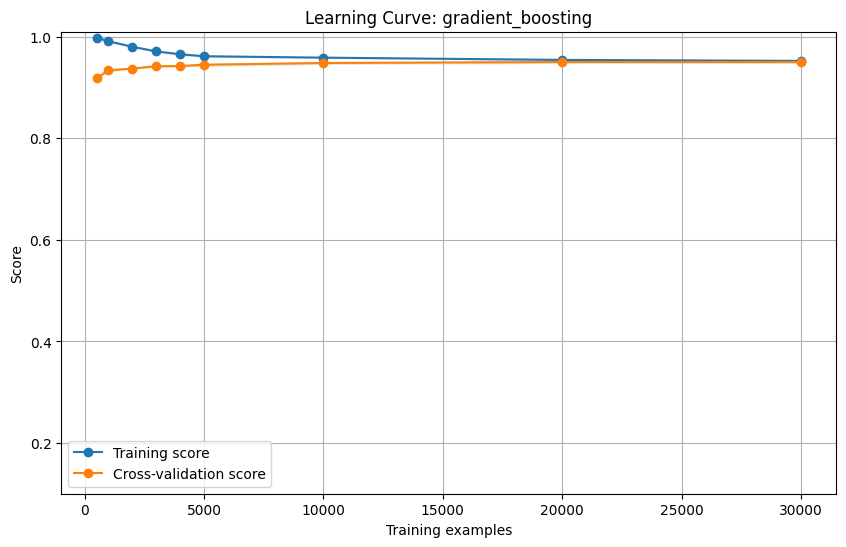

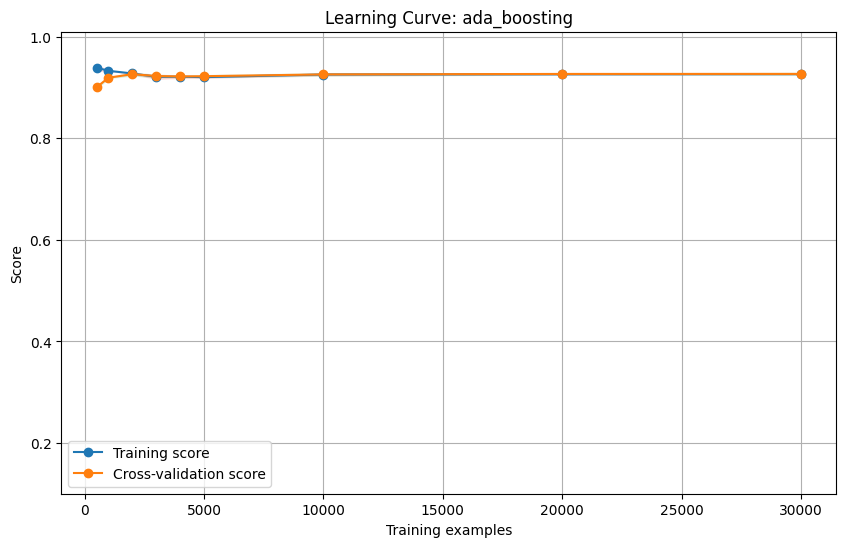

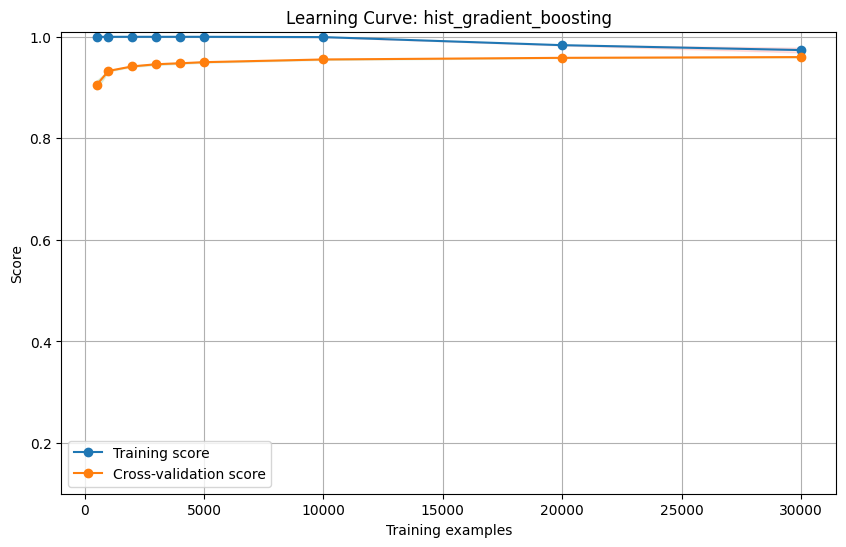

In [4]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curve(estimator, title, X, y, train_sizes=None, ylim=(0.1, 1.01), cv=5, n_jobs=-1):
    """
    Trace la courbe d'apprentissage pour un modèle donné.

    :param estimator: Modèle optimisé à évaluer.
    :param title: Titre de la courbe.
    :param X: Features d'entrée.
    :param y: Target.
    :param train_sizes: Liste des tailles d'échantillons d'entraînement (fractions ou nombres absolus).
    :param ylim: Limites des scores (axe y).
    :param cv: Nombre de folds pour la validation croisée.
    :param n_jobs: Nombre de jobs parallèles.
    """
    if train_sizes is None:
        train_sizes = [500, 1000, 2000, 3000, 4000, 5000, 10000, 20000, 30000]  # Tailles spécifiques

    # Limiter la taille maximale en fonction des données
    n_samples = len(X)
    train_sizes = [size for size in train_sizes if size <= n_samples]

    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.ylim(*ylim)

    # Calcul des courbes d'apprentissage
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, train_sizes=train_sizes, cv=cv, n_jobs=n_jobs, scoring="accuracy"
    )

    # Moyenne et écart-type des scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Tracé des courbes avec les intervalles de confiance
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score")

    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Tracer les courbes pour les modèles optimisés
for name, model in best_models.items():
    plot_learning_curve(
        model, 
        f"Learning Curve: {name}", 
        X, 
        y, 
        train_sizes=[500, 1000, 2000, 3000, 4000, 5000, 10000, 20000, 30000], 
        ylim=(0.1, 1.01)
    )

In [8]:
import optuna
from sklearn.model_selection import cross_val_score

# Définir la fonction objectif pour Optuna
def objective(trial):
    # Paramètres à optimiser
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 1.0, log=True),
        "max_iter": trial.suggest_int("max_iter", 50, 1000),  # Equivalent de n_estimators
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 50),
        "l2_regularization": trial.suggest_float("l2_regularization", 0.0, 10.0),
        "max_bins": trial.suggest_int("max_bins", 32, 255),
        "early_stopping": trial.suggest_categorical("early_stopping", [True, False]),
    }

    # Modèle et pipeline
    model = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", HistGradientBoostingClassifier(random_state=42, **params))
    ])

    # Validation croisée
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy", n_jobs=-1)
    return scores.mean()

# Étudier les hyperparamètres avec Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200)

# Meilleurs paramètres
print("Best hyperparameters:", study.best_params)
print("Best accuracy:", study.best_value)

# Entraîner et évaluer le meilleur modèle
best_params = study.best_params
best_model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", HistGradientBoostingClassifier(random_state=42, **best_params))
])

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))

[I 2024-12-13 19:12:00,420] A new study created in memory with name: no-name-87bbe1c0-56af-4da0-a716-ff91268857c2
[I 2024-12-13 19:12:05,733] Trial 0 finished with value: 0.9619264015460928 and parameters: {'learning_rate': 0.3823331518404681, 'max_iter': 198, 'max_depth': 10, 'min_samples_leaf': 6, 'l2_regularization': 0.6547051327788145, 'max_bins': 108, 'early_stopping': False}. Best is trial 0 with value: 0.9619264015460928.
[I 2024-12-13 19:12:24,239] Trial 1 finished with value: 0.9597609401939907 and parameters: {'learning_rate': 0.006641412011128132, 'max_iter': 851, 'max_depth': 17, 'min_samples_leaf': 9, 'l2_regularization': 4.157215585340932, 'max_bins': 222, 'early_stopping': False}. Best is trial 0 with value: 0.9619264015460928.
[I 2024-12-13 19:12:33,132] Trial 2 finished with value: 0.9254504213911622 and parameters: {'learning_rate': 0.017541860073309982, 'max_iter': 968, 'max_depth': 1, 'min_samples_leaf': 26, 'l2_regularization': 5.314681656876331, 'max_bins': 94, 'e

Best hyperparameters: {'learning_rate': 0.03400676560252863, 'max_iter': 925, 'max_depth': 13, 'min_samples_leaf': 16, 'l2_regularization': 8.763352346928274, 'max_bins': 209, 'early_stopping': False}
Best accuracy: 0.9653045224966039
Test Accuracy: 0.9643132121958731


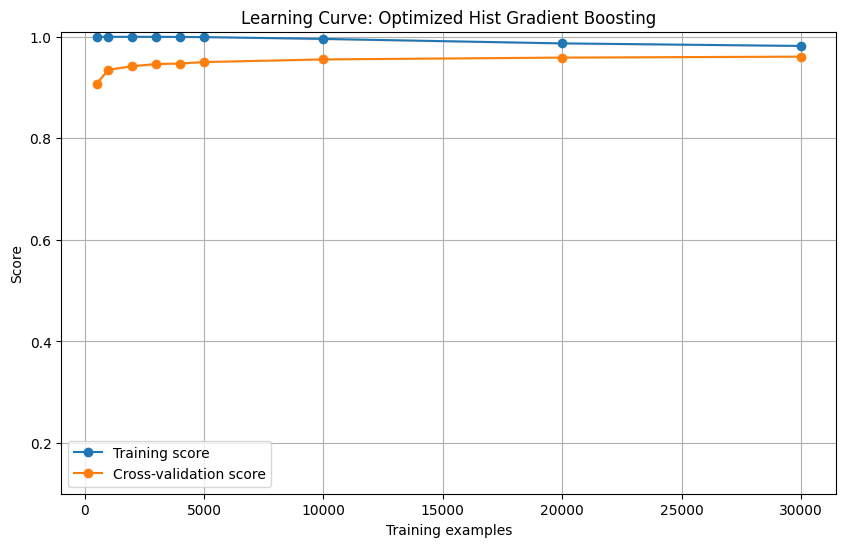

In [9]:
# Tracer la courbe d'apprentissage
plot_learning_curve(
        best_model, 
        "Learning Curve: Optimized Hist Gradient Boosting",
        X, 
        y, 
        train_sizes=[500, 1000, 2000, 3000, 4000, 5000, 10000, 20000, 30000], 
        ylim=(0.1, 1.01)
    )